# Wasserstein Distances

Import Libraries

In [1]:
import os
import random
import glob
import sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.stats as stats

sys.path.append(os.path.abspath('./../../sdo_augmentation/'))
from augmentation import Augmentations


# Calculating the 1D Power Spectrum

In [3]:
# Calculates 1d Power Spectrum
def power_spectrum_1d(image):

    #Get pixel count
    pixel_count = image.shape[0]

    # Convert into fourier transform
    fourier_image = np.fft.fftn(image)
    fourier_amplitudes = np.abs(fourier_image)

    #Calculate 1D power spectrum
    k_frequencies = np.fft.fftfreq(pixel_count) * pixel_count
    k_frequencies2D = np.meshgrid(k_frequencies, k_frequencies)
    k_norm = np.sqrt(k_frequencies2D[0] ** 2 + k_frequencies2D[1] ** 2)
    k_bins = np.arange(0.5, pixel_count // 2 + 1, 1.)
    k_vals = 0.5 * (k_bins[1:] + k_bins[:-1])
    a_bins, _, _ = stats.binned_statistic(k_norm.flatten(),
                                        (fourier_amplitudes ** 2).flatten(),
                                        statistic = "mean", bins = k_bins)
    a_bins *= np.pi * (k_bins[1:] ** 2 - k_bins[:-1] ** 2)
    return a_bins

# Investigating Rotation

Select image and rotate the image in 10 different ways

In [5]:
# Open image
image_path = './../../AIA171_Miniset_BW/20130217_000001_aia_171_4k/tiles/20130217_000001_aia_171_4k_tile_1024_3072.jpg'
image = np.array(Image.open(image_path).convert('L'))
image = image.astype(float) / 255

# Create set of degrees to rotate
set_degrees = np.arange(0, 50, 5)
rotated_images = []
power_spectrums = []
wasserstein_distances = []
pixel_count = image.shape[0]


for j, i in enumerate(set_degrees):
    
    # Create rotated image
    augmentation = Augmentations(image, {'rotate': i})
    rotated_image, _ = augmentation.perform_augmentations(fill_void = 'Nearest')
    rotated_images.append(rotated_image)

    power_spectrums.append(power_spectrum_1d(rotated_image))

    # Calculate Wasserstein Distance of original image vs rotated iamge
    if not i == 0:
        wasserstein_distance = stats.wasserstein_distance(power_spectrums[0], power_spectrums[j])
        wasserstein_distances.append(wasserstein_distance)
        print('Degree:', i, 'Wasserstein Distance:', wasserstein_distance)



Degree: 5 Wasserstein Distance: 401.43595902182574
Degree: 10 Wasserstein Distance: 650.6555066550484
Degree: 15 Wasserstein Distance: 1013.1218577325553
Degree: 20 Wasserstein Distance: 1137.6342363470571
Degree: 25 Wasserstein Distance: 1275.7059189317083
Degree: 30 Wasserstein Distance: 1586.4448779904944
Degree: 35 Wasserstein Distance: 1816.7051581467972
Degree: 40 Wasserstein Distance: 1754.4923491491168
Degree: 45 Wasserstein Distance: 1589.957596512647


Compare Origional Image with Augmented Image

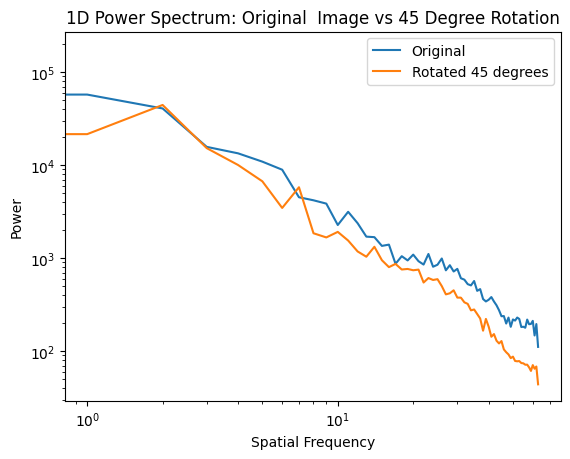

In [6]:
#fig, axs = plt.subplots(2, 2, figsize = (10, 10))

index = 9

plt.title('1D Power Spectrum: Original  Image vs ' + str(set_degrees[index]) + ' Degree Rotation')

plt.loglog(power_spectrums[0], label = 'Original')
plt.loglog(power_spectrums[index], label = 'Original')
plt.legend(['Original', 'Rotated ' + str(set_degrees[index]) + ' degrees'])
plt.xlabel('Spatial Frequency')
plt.ylabel('Power')
plt.show()


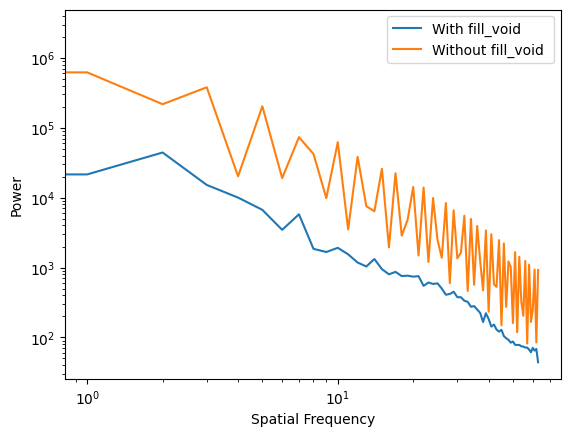

In [7]:
augmentation = Augmentations(image, {'rotate': 45})
rotated_image1, _ = augmentation.perform_augmentations(fill_void = 'Nearest')
rotated_image2, _ = augmentation.perform_augmentations()
test = []

for i in [rotated_image1, rotated_image2]:

    # Convert into fourier transform
    fourier_rotated_image = np.fft.fftn(i)
    fourier_rotated_amplitudes = np.abs(fourier_rotated_image)

    #Calculate 1D power spectrum
    k_frequencies = np.fft.fftfreq(pixel_count) * pixel_count
    k_frequencies2D = np.meshgrid(k_frequencies, k_frequencies)
    k_norm = np.sqrt(k_frequencies2D[0] ** 2 + k_frequencies2D[1] ** 2)
    k_bins = np.arange(0.5, pixel_count // 2 + 1, 1.)
    k_vals = 0.5 * (k_bins[1:] + k_bins[:-1])
    a_bins, _, _ = stats.binned_statistic(k_norm.flatten(),
                                        (fourier_rotated_amplitudes ** 2).flatten(),
                                        statistic = "mean", bins = k_bins)
    a_bins *= np.pi * (k_bins[1:] ** 2 - k_bins[:-1] ** 2)

    test.append(a_bins)


plt.loglog(test[0])
plt.loglog(test[1])
plt.legend(['With fill_void', 'Without fill_void '])
plt.xlabel('Spatial Frequency')
plt.ylabel('Power')
plt.show()